# Capstone Project by Nicolas de Wergifosse

---

#### Introduction/Business Problem :

Who : Am an investor in the health sector.

What : I plan to buy a building and open a new crossfit center.

Where : In Paris "intra muros".

When : As soon as I am certain about the neighborhood where to locate it.

Why : Because it's a new trend that clearly exploded recently and customers are looking for having a crossfit center closed to home.



#### Data

For this project we need the following data :

* Paris neighborhoods with their postal code, the population density, the price per square meter and their latitude and longitude.

    Data source : [Paris dataset](https://fr.wikipedia.org/wiki/Arrondissements_de_Paris)
     
    Description : This data set contains the required information that will be used to explore various locality of Paris.
  
  
* Nearby places in each locality of new Paris city.

    Data source : [Foursquare API](https://developer.foursquare.com/)

    Description : By using this api we will get all the crossfit centers in each neighborhood.

---

Import all the necessary libraries :

In [1]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 112kB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 5.8MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | #

Connect to the Foursquare API using personal credentials :

In [7]:
CLIENT_ID = 'JQTBOUDNJ5X50MOGXTW3JPHPAGRMSSKF40KKF5HWZLIWOXCO' # your Foursquare ID
CLIENT_SECRET = 'I0WCZEH2V0MQMHGHR404JEPXORYA5CGSUM251OIC5V15PLBW' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JQTBOUDNJ5X50MOGXTW3JPHPAGRMSSKF40KKF5HWZLIWOXCO
CLIENT_SECRET:I0WCZEH2V0MQMHGHR404JEPXORYA5CGSUM251OIC5V15PLBW


Build the data frame :

In [8]:
paris = {'Borough': ['75001','75002','75003','75004','75005','75006','75007','75008','75009','75010','75011','75012','75013','75014','75015','75016','75017','75018','75019','75020'],
        'Neighborhood': ['Louvre','Bourse','Temple','Hotel de Ville','Panthéon','Luxembourg','Palais Bourbon','Elysée','Opéra','Saint Laurent','Popincourt','Reuilly','Gobelins','Observatoire','Vaugirard','Passy','Batignolles','Montmartre','Buttes Chaumont','Ménilmontant'],
        'Density': [9041,21006,29956,16966,23359,19734,13235,9457,27251,31754,40827,22345,25625,24821,27712,20921,29724,32875,27342,32702],
        'Pricem2': [13681,12274,12919,13655,13107,15416,14650,13160,11623,10439,10779,10041,9969,10702,10783,11903,11204,9990,8895,9127],
        'Latitude': [48.859200,48.865500,48.863700,48.860100,48.8448,48.849300,48.856500,48.876300,48.871800,48.870900,48.857400,48.841200,48.832200,48.833100,48.841200,48.863700,48.883500,48.892500,48.881700,48.864600],
        'Longitude': [2.341700,2.342600,2.361500,2.350700,2.347100,2.330000,2.321000,2.318300,2.339900,2.356100,2.379500,2.387600,2.356100,2.326400,2.300300,2.276900,2.321900,2.344400,2.382200,2.398400]
        }

df = pd.DataFrame(paris, columns = ['Borough','Neighborhood','Density','Pricem2','Latitude','Longitude'])

print (df)

   Borough     Neighborhood  Density  Pricem2  Latitude  Longitude
0    75001           Louvre     9041    13681   48.8592     2.3417
1    75002           Bourse    21006    12274   48.8655     2.3426
2    75003           Temple    29956    12919   48.8637     2.3615
3    75004   Hotel de Ville    16966    13655   48.8601     2.3507
4    75005         Panthéon    23359    13107   48.8448     2.3471
5    75006       Luxembourg    19734    15416   48.8493     2.3300
6    75007   Palais Bourbon    13235    14650   48.8565     2.3210
7    75008           Elysée     9457    13160   48.8763     2.3183
8    75009            Opéra    27251    11623   48.8718     2.3399
9    75010    Saint Laurent    31754    10439   48.8709     2.3561
10   75011       Popincourt    40827    10779   48.8574     2.3795
11   75012          Reuilly    22345    10041   48.8412     2.3876
12   75013         Gobelins    25625     9969   48.8322     2.3561
13   75014     Observatoire    24821    10702   48.8331     2.

Using Foursquare API, let's find info on the crossfit and fitness centers in each neighborhood :

In [11]:
address = '75000, Paris, France'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

48.8566969 2.3514616


In [12]:
search_query = 'crossfit'
radius = 10000
print(search_query + ' .... OK!')

crossfit .... OK!


In [13]:
# Get the Foursquare URL :
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=JQTBOUDNJ5X50MOGXTW3JPHPAGRMSSKF40KKF5HWZLIWOXCO&client_secret=I0WCZEH2V0MQMHGHR404JEPXORYA5CGSUM251OIC5V15PLBW&ll=48.8566969,2.3514616&v=20180604&query=crossfit&radius=10000&limit=30'

In [14]:
# Extract results from Foursquare DB :
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb53c3a0de0d9001b1a8cda'},
 'response': {'venues': [{'id': '53e796e1498ed133e2e63026',
    'name': 'CrossFit Lutèce',
    'location': {'address': '4 Rue Jules Simon',
     'lat': 48.84088808067835,
     'lng': 2.292198728602586,
     'labeledLatLngs': [{'label': 'display',
       'lat': 48.84088808067835,
       'lng': 2.292198728602586}],
     'distance': 4684,
     'postalCode': '92015',
     'cc': 'FR',
     'city': 'Paris',
     'state': 'Île-de-France',
     'country': 'France',
     'formattedAddress': ['4 Rue Jules Simon', '92015 Paris', 'France']},
    'categories': [{'id': '4bf58dd8d48988d176941735',
      'name': 'Gym',
      'pluralName': 'Gyms',
      'shortName': 'Gym',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1588935757',
    'hasPerk': False},
   {'id': '56a7c54b498e2517c6b9760b',
    'name': 'CrossFit Original Addicts II',

Clean up the data :

In [16]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head(30)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood
0,53e796e1498ed133e2e63026,CrossFit Lutèce,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588935757,False,4 Rue Jules Simon,48.840888,2.292199,"[{'label': 'display', 'lat': 48.84088808067835...",4684,92015,FR,Paris,Île-de-France,France,"[4 Rue Jules Simon, 92015 Paris, France]",NaN,NaN
1,56a7c54b498e2517c6b9760b,CrossFit Original Addicts II,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588935757,False,37 Rue Bréguet,48.858407,2.375695,"[{'label': 'display', 'lat': 48.85840655301172...",1785,75011,FR,Paris,Île-de-France,France,"[37 Rue Bréguet, 75011 Paris, France]",NaN,NaN
2,4fa81d41e4b0d6f4be98c6bd,Reebok CrossFit Louvre,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588935757,False,31 avenue de l'Opéra,48.867266,2.333469,"[{'label': 'display', 'lat': 48.86726626129496...",1766,75002,FR,Paris,Île-de-France,France,"[31 avenue de l'Opéra, 75002 Paris, France]",NaN,NaN
3,54b7ce9c498ef19600d79341,CrossFit XIII,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588935757,False,14 rue de Vandrezanne,48.828197,2.356445,"[{'label': 'display', 'lat': 48.82819749353125...",3193,75013,FR,Paris,Île-de-France,France,"[14 rue de Vandrezanne, 75013 Paris, France]",NaN,NaN
4,506083cee4b0351d980fe540,CrossFit Original Addicts,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588935757,False,NaN,48.852923,2.397880,"[{'label': 'display', 'lat': 48.85292326371746...",3425,NaN,FR,NaN,NaN,France,[France],NaN,NaN
5,5de2304b18f0a7000753c237,Crossfit Lutèce 2,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588935757,False,33 Rue de l'Église,48.844703,2.286984,"[{'label': 'display', 'lat': 48.844703, 'lng':...",4908,75015,FR,Paris,Île-de-France,France,"[33 Rue de l'Église, 75015 Paris, France]",NaN,NaN
6,57fe6afc498efbce0b9b0cda,Silvaticus CrossFit,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588935757,False,220 Boulevard Voltaire,48.852986,2.387952,"[{'label': 'display', 'lat': 48.852986, 'lng':...",2704,75011,FR,Paris,Île-de-France,France,"[220 Boulevard Voltaire, 75011 Paris, France]",NaN,NaN
7,5dd636e883e1910007c80280,Reebok Crossfit Louvre 3,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588935757,False,24 Rue De Londres,48.877383,2.328346,"[{'label': 'display', 'lat': 48.877383, 'lng':...",2857,75009,FR,Paris,Île-de-France,France,"[24 Rue De Londres, 75009 Paris, France]",NaN,NaN
8,561cdc0c498e5051b09b6bd0,Crossfit Gavroche,"[{'id': '52e81612bcbc57f1066b7a2e', 'name': 'S...",v-1588935757,False,29 rue des Peupliers,48.834295,2.257010,"[{'label': 'display', 'lat': 48.83429508957410...",7354,92100,FR,Boulogne-Billancourt,Île-de-France,France,"[29 rue des Peupliers, 92100 Boulogne-Billanco...",NaN,NaN
9,589c28a001f07775462fe708,CrossFit - Les Enfants de la Barre,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1588935757,False,156 Maurice Arnoux,48.811717,2.308539,"[{'label': 'display', 'lat': 48.81171699999999...",5912,92120,FR,Montrouge,Île-de-France,France,"[156 Maurice Arnoux, 92120 Montrouge, France]",398176735,NaN


In [56]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Fitness - Hôtel Maison Albar Paris Céline,Gym / Fitness Center,Hôtel Maison Albar Paris Céline,23-25 rue du Pont Neuf,48.860569,2.344233,"[{'label': 'display', 'lat': 48.860569, 'lng':...",682,75001,FR,Paris,Île-de-France,France,[Hôtel Maison Albar Paris Céline (23-25 rue du...,NaN,5a45f1029cadd96868f6db45
1,Temple Gym and Fitness,Gym,NaN,NaN,48.864591,2.353936,"[{'label': 'display', 'lat': 48.864591, 'lng':...",897,75003,FR,Paris,Île-de-France,France,"[75003 Paris, France]",NaN,54c67dab498eb4050f6557af
2,Fitness Park Paris - Diderot,Gym / Fitness Center,60-62 Boulevard Diderot,NaN,48.846438,2.380495,"[{'label': 'display', 'lat': 48.84643793617312...",2413,75012,FR,Paris,Île-de-France,France,"[60-62 Boulevard Diderot, 75012 Paris, France]",NaN,597aecd74c954c5a4e610941
3,Fitness Centre,Gym / Fitness Center,251 rue Saint-Honoré,NaN,48.866758,2.327074,"[{'label': 'display', 'lat': 48.866758, 'lng':...",2108,75001,FR,Paris,Île-de-France,France,"[251 rue Saint-Honoré, 75001 Paris, France]",NaN,56fa0c44498e82faa84386c0
4,Hotel Duo Fitness Centre,Gym / Fitness Center,NaN,NaN,48.858094,2.352975,"[{'label': 'display', 'lat': 48.858094, 'lng':...",190,NaN,FR,NaN,NaN,France,[France],NaN,58a4b35d52e32d4ecc831c92
5,Fitness La Villa Haussmann,Gym / Fitness Center,132 boulevard Haussmann,Hôtel La Villa Haussmann,48.875332,2.316707,"[{'label': 'display', 'lat': 48.87533216897898...",3283,75008,FR,Paris,Île-de-France,France,[132 boulevard Haussmann (Hôtel La Villa Hauss...,NaN,59364fdb04d1ae59f759b00b
6,Fitness Park Paris - Chevaleret,Gym / Fitness Center,81-83 Rue du Chevaleret,NaN,48.829313,2.375797,"[{'label': 'display', 'lat': 48.82931294591551...",3531,75013,FR,Paris,Île-de-France,France,"[81-83 Rue du Chevaleret, 75013 Paris, France]",NaN,590993dd8173cb4121a42c96
7,Fitness Park Paris - 20ème,Gym / Fitness Center,65 rue de bagnolet,NaN,48.857619,2.399182,"[{'label': 'display', 'lat': 48.85761902661403...",3496,75020,FR,Paris,Île-de-France,France,"[65 rue de bagnolet, 75020 Paris, France]",NaN,5caf1595666116002cf8a4c6
8,Fitness Boutique,Miscellaneous Shop,85 boulevard de Sébastopol,NaN,48.864836,2.351829,"[{'label': 'display', 'lat': 48.86483557382158...",906,75001,FR,Paris,Île-de-France,France,"[85 boulevard de Sébastopol, 75001 Paris, France]",NaN,517bda7fe4b0a366c527f562
9,Fitness Park Paris - Théâtre,Gym / Fitness Center,104 bis rue du Théâtre,NaN,48.846387,2.294405,"[{'label': 'display', 'lat': 48.8463871, 'lng'...",4334,75015,FR,Paris,Île-de-France,France,"[104 bis rue du Théâtre, 75015 Paris, France]",NaN,57f2ce36498eab566752eeb3


Extract the number of crossfit centers per "Arrondissement" and aggregate it in the dataset :

In [59]:
dataframe_filtered.groupby('postalCode').postalCode.count()

postalCode
75001    3
75003    2
75005    1
75008    2
75009    1
75011    3
75012    2
75013    2
75014    1
75015    1
75018    1
75020    1
92120    1
92130    1
92400    1
93000    1
94110    1
Name: postalCode, dtype: int64

Same approach to extarct gyms/fitness centers information from Foursquare :

In [17]:
search_query = 'fitness'
radius = 10000
print(search_query + ' .... OK!')

fitness .... OK!


In [18]:
# Get the Foursquare URL :
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=JQTBOUDNJ5X50MOGXTW3JPHPAGRMSSKF40KKF5HWZLIWOXCO&client_secret=I0WCZEH2V0MQMHGHR404JEPXORYA5CGSUM251OIC5V15PLBW&ll=48.8566969,2.3514616&v=20180604&query=fitness&radius=10000&limit=30'

In [19]:
# Extract results from Foursquare DB :
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb543fa5fb726001bd1a206'},
 'response': {'venues': [{'id': '5a45f1029cadd96868f6db45',
    'name': 'Fitness - Hôtel Maison Albar Paris Céline',
    'location': {'address': 'Hôtel Maison Albar Paris Céline',
     'crossStreet': '23-25 rue du Pont Neuf',
     'lat': 48.860569,
     'lng': 2.344233,
     'labeledLatLngs': [{'label': 'display',
       'lat': 48.860569,
       'lng': 2.344233}],
     'distance': 682,
     'postalCode': '75001',
     'cc': 'FR',
     'city': 'Paris',
     'state': 'Île-de-France',
     'country': 'France',
     'formattedAddress': ['Hôtel Maison Albar Paris Céline (23-25 rue du Pont Neuf)',
      '75001 Paris',
      'France']},
    'categories': [{'id': '4bf58dd8d48988d175941735',
      'name': 'Gym / Fitness Center',
      'pluralName': 'Gyms or Fitness Centers',
      'shortName': 'Gym / Fitness',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
       'suffix': '.png'},
      'primary'

Clean the data :

In [79]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe2 = json_normalize(venues)
dataframe2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,5a45f1029cadd96868f6db45,Fitness - Hôtel Maison Albar Paris Céline,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588937543,False,Hôtel Maison Albar Paris Céline,23-25 rue du Pont Neuf,48.860569,2.344233,"[{'label': 'display', 'lat': 48.860569, 'lng':...",682,75001,FR,Paris,Île-de-France,France,[Hôtel Maison Albar Paris Céline (23-25 rue du...,NaN
1,54c67dab498eb4050f6557af,Temple Gym and Fitness,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1588937543,False,NaN,NaN,48.864591,2.353936,"[{'label': 'display', 'lat': 48.864591, 'lng':...",897,75003,FR,Paris,Île-de-France,France,"[75003 Paris, France]",NaN
2,597aecd74c954c5a4e610941,Fitness Park Paris - Diderot,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588937543,False,60-62 Boulevard Diderot,NaN,48.846438,2.380495,"[{'label': 'display', 'lat': 48.84643793617312...",2413,75012,FR,Paris,Île-de-France,France,"[60-62 Boulevard Diderot, 75012 Paris, France]",NaN
3,56fa0c44498e82faa84386c0,Fitness Centre,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588937543,False,251 rue Saint-Honoré,NaN,48.866758,2.327074,"[{'label': 'display', 'lat': 48.866758, 'lng':...",2108,75001,FR,Paris,Île-de-France,France,"[251 rue Saint-Honoré, 75001 Paris, France]",NaN
4,58a4b35d52e32d4ecc831c92,Hotel Duo Fitness Centre,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",v-1588937543,False,NaN,NaN,48.858094,2.352975,"[{'label': 'display', 'lat': 48.858094, 'lng':...",190,NaN,FR,NaN,NaN,France,[France],NaN


In [80]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
dataframe2_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe2_filtered['categories'] = dataframe2_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe2_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe2_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Fitness - Hôtel Maison Albar Paris Céline,Gym / Fitness Center,Hôtel Maison Albar Paris Céline,23-25 rue du Pont Neuf,48.860569,2.344233,"[{'label': 'display', 'lat': 48.860569, 'lng':...",682,75001,FR,Paris,Île-de-France,France,[Hôtel Maison Albar Paris Céline (23-25 rue du...,NaN,5a45f1029cadd96868f6db45
1,Temple Gym and Fitness,Gym,NaN,NaN,48.864591,2.353936,"[{'label': 'display', 'lat': 48.864591, 'lng':...",897,75003,FR,Paris,Île-de-France,France,"[75003 Paris, France]",NaN,54c67dab498eb4050f6557af
2,Fitness Park Paris - Diderot,Gym / Fitness Center,60-62 Boulevard Diderot,NaN,48.846438,2.380495,"[{'label': 'display', 'lat': 48.84643793617312...",2413,75012,FR,Paris,Île-de-France,France,"[60-62 Boulevard Diderot, 75012 Paris, France]",NaN,597aecd74c954c5a4e610941
3,Fitness Centre,Gym / Fitness Center,251 rue Saint-Honoré,NaN,48.866758,2.327074,"[{'label': 'display', 'lat': 48.866758, 'lng':...",2108,75001,FR,Paris,Île-de-France,France,"[251 rue Saint-Honoré, 75001 Paris, France]",NaN,56fa0c44498e82faa84386c0
4,Hotel Duo Fitness Centre,Gym / Fitness Center,NaN,NaN,48.858094,2.352975,"[{'label': 'display', 'lat': 48.858094, 'lng':...",190,NaN,FR,NaN,NaN,France,[France],NaN,58a4b35d52e32d4ecc831c92
5,Fitness La Villa Haussmann,Gym / Fitness Center,132 boulevard Haussmann,Hôtel La Villa Haussmann,48.875332,2.316707,"[{'label': 'display', 'lat': 48.87533216897898...",3283,75008,FR,Paris,Île-de-France,France,[132 boulevard Haussmann (Hôtel La Villa Hauss...,NaN,59364fdb04d1ae59f759b00b
6,Fitness Park Paris - Chevaleret,Gym / Fitness Center,81-83 Rue du Chevaleret,NaN,48.829313,2.375797,"[{'label': 'display', 'lat': 48.82931294591551...",3531,75013,FR,Paris,Île-de-France,France,"[81-83 Rue du Chevaleret, 75013 Paris, France]",NaN,590993dd8173cb4121a42c96
7,Fitness Park Paris - 20ème,Gym / Fitness Center,65 rue de bagnolet,NaN,48.857619,2.399182,"[{'label': 'display', 'lat': 48.85761902661403...",3496,75020,FR,Paris,Île-de-France,France,"[65 rue de bagnolet, 75020 Paris, France]",NaN,5caf1595666116002cf8a4c6
8,Fitness Boutique,Miscellaneous Shop,85 boulevard de Sébastopol,NaN,48.864836,2.351829,"[{'label': 'display', 'lat': 48.86483557382158...",906,75001,FR,Paris,Île-de-France,France,"[85 boulevard de Sébastopol, 75001 Paris, France]",NaN,517bda7fe4b0a366c527f562
9,Fitness Park Paris - Théâtre,Gym / Fitness Center,104 bis rue du Théâtre,NaN,48.846387,2.294405,"[{'label': 'display', 'lat': 48.8463871, 'lng'...",4334,75015,FR,Paris,Île-de-France,France,"[104 bis rue du Théâtre, 75015 Paris, France]",NaN,57f2ce36498eab566752eeb3


In [81]:
dataframe2_filtered.groupby('postalCode').postalCode.count()

postalCode
75001    3
75003    2
75005    1
75008    2
75009    1
75011    3
75012    2
75013    2
75014    1
75015    1
75018    1
75020    1
92120    1
92130    1
92400    1
93000    1
94110    1
Name: postalCode, dtype: int64

Add CrossFit and fitness centers information in the original dataframe :

In [43]:
#Add the number of crossfit centers as a new column in the dataframe :

crossfit = [0,1,0,0,0,0,0,0,1,0,2,0,1,0,1,0,0,0,0,0]
df['Crossfit_centers'] = crossfit
df

,Borough,Neighborhood,Density,Pricem2,Latitude,Longitude,Crossfit_centers,Crossfit,Fitness_centers
0,75001,Louvre,9041,13681,48.8592,2.3417,0,0,3
1,75002,Bourse,21006,12274,48.8655,2.3426,1,1,0
2,75003,Temple,29956,12919,48.8637,2.3615,0,0,2
3,75004,Hotel de Ville,16966,13655,48.8601,2.3507,0,0,0
4,75005,Panthéon,23359,13107,48.8448,2.3471,0,0,1
5,75006,Luxembourg,19734,15416,48.8493,2.3300,0,0,0
6,75007,Palais Bourbon,13235,14650,48.8565,2.3210,0,0,0
7,75008,Elysée,9457,13160,48.8763,2.3183,0,0,2
8,75009,Opéra,27251,11623,48.8718,2.3399,1,1,1
9,75010,Saint Laurent,31754,10439,48.8709,2.3561,0,0,0


In [46]:
#Add the number of fitness centers as a new column in the dataframe :

fitness = [3,0,2,0,1,0,0,2,1,0,3,2,2,1,1,0,0,1,0,1]
df['Fitness_centers'] = fitness
df
df.drop(columns=['Crossfit'])

,Borough,Neighborhood,Density,Pricem2,Latitude,Longitude,Crossfit_centers,Fitness_centers
0,75001,Louvre,9041,13681,48.8592,2.3417,0,3
1,75002,Bourse,21006,12274,48.8655,2.3426,1,0
2,75003,Temple,29956,12919,48.8637,2.3615,0,2
3,75004,Hotel de Ville,16966,13655,48.8601,2.3507,0,0
4,75005,Panthéon,23359,13107,48.8448,2.3471,0,1
5,75006,Luxembourg,19734,15416,48.8493,2.3300,0,0
6,75007,Palais Bourbon,13235,14650,48.8565,2.3210,0,0
7,75008,Elysée,9457,13160,48.8763,2.3183,0,2
8,75009,Opéra,27251,11623,48.8718,2.3399,1,1
9,75010,Saint Laurent,31754,10439,48.8709,2.3561,0,0


Visualize the CrossFit centers extracted from Foursquare on a Folium map :

In [88]:
crossfit_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Paris


# add a red circle marker to represent Paris
folium.features.CircleMarker(
    [latitude, longitude],
    radius=5,
    color='red',
    popup='Paris',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(crossfit_map)

# add the Crossfit centers as green circle markers
for lat, lng, name in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(crossfit_map)
   
    
# display map
crossfit_map

Build histogram of Population Density (Pop./km2) across Arrondissements in Paris :

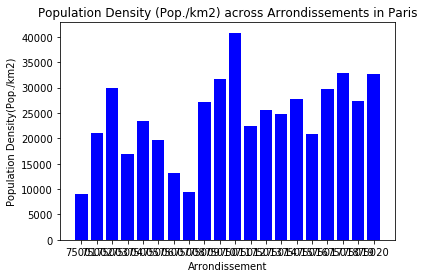

In [97]:
import matplotlib.pyplot as plt

plt.bar("Borough","Density", data = df, color = "blue")

plt.xlabel("Arrondissement")
plt.ylabel("Population Density(Pop./km2)")
plt.title("Population Density (Pop./km2) across Arrondissements in Paris")

plt.show()

Build histogram of Property Price (EUR/m2) across Arrondissements in Paris :

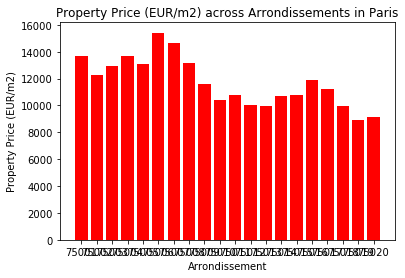

In [96]:
import matplotlib.pyplot as plt

plt.bar("Borough","Pricem2", data = df, color = "red")

plt.xlabel("Arrondissement")
plt.ylabel("Property Price (EUR/m2)")
plt.title("Property Price (EUR/m2) across Arrondissements in Paris")

plt.show()

#### Step 9 : Conclusion

By investigating location data, property prices, and population densities, it is possible to come to the conclusion that the 18th or 19th arrondissements would pose as the best location to open a CrossFit center. In particular, the 19th arrondissement serves as a very interesting opportunity because of the following reasons:

* No other CrossFit center in the neighborhood.

* Other gyms/fitness centers are successful in the area, meaning the target customers are there. Same principle as opening a Burger King next to a Mc Donald.

* The population density is as high as in the South of Paris were the concept of CrossFit centers has already been a success.

* Lower property price compared to surrounding Arrondissements. The migration wave to the North of Paris has started and better to be there in time before prices reach Paris regular property prices.

* Proximity from multiple working area where big companies opened office centers for similar economic reasons (like BNP Real Estate who heavily invested in this area).

